In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
warnings.filterwarnings('ignore') 

# Sources:
- https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment
- https://huggingface.co/DGurgurov/xlm-r_romanian_sentiment
- https://huggingface.co/dumitrescustefan/bert-base-romanian-cased-v1

In [3]:
!pip uninstall -y wandb
!pip install wandb==0.17.5 
import wandb
!wandb offline
!wandb disabled
import os
os.environ["WANDB_DISABLED"] = "true"

Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 54.9 MB/s eta 0:00:0000:0100:01
W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


# Install Libraries and Modules

In [4]:
!pip install -q datasets transformers evaluate sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.7 MB/s eta 0:00:0000:01


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [6]:
train_ron = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_b/train/ron.csv")

dev_ron = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_b/dev/ron.csv")

test_ron = pd.read_csv("/kaggle/input/semeval-2025-task-11-emotion/public_data_test/track_b/test/ron.csv")

# ROMANIAN

In [9]:
train_ron.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,ron_train_track_b_00001,Ce surpriza Miai inseninat ziua Ce invitata mi...,0,0,0,3,0,3
1,ron_train_track_b_00002,Parlamentarii vor închisoare pentru cine nu pa...,0,0,0,0,0,0
2,ron_train_track_b_00003,<|PERSON|> declarații de presă la 2230 Prima i...,0,0,0,0,0,1
3,ron_train_track_b_00004,O ador pe <|PERSON|> O urmaresc de multi ani p...,0,0,0,2,0,0
4,ron_train_track_b_00005,am visat niste chestii ciudate pe care efectiv...,0,0,3,0,0,1


In [10]:
train_ron.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1241 entries, 0 to 1240
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1241 non-null   object
 1   text      1241 non-null   object
 2   anger     1241 non-null   int64 
 3   disgust   1241 non-null   int64 
 4   fear      1241 non-null   int64 
 5   joy       1241 non-null   int64 
 6   sadness   1241 non-null   int64 
 7   surprise  1241 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 77.7+ KB


<Axes: >

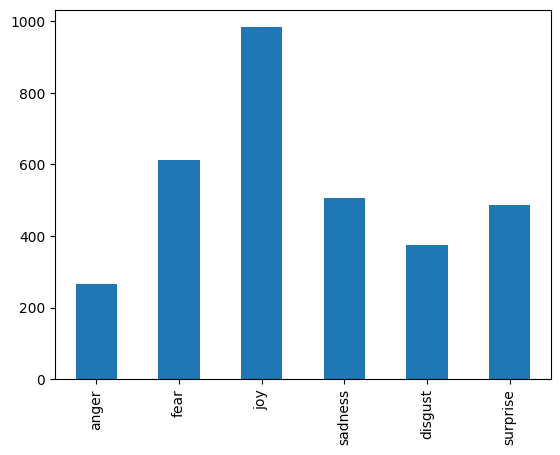

In [15]:
attributes = ['anger', 'fear', 'joy', 'sadness', 'disgust','surprise']
train_ron[attributes].sum().plot.bar()

In [11]:
dev_ron.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        123 non-null    object
 1   text      123 non-null    object
 2   anger     123 non-null    int64 
 3   disgust   123 non-null    int64 
 4   fear      123 non-null    int64 
 5   joy       123 non-null    int64 
 6   sadness   123 non-null    int64 
 7   surprise  123 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 7.8+ KB


<Axes: >

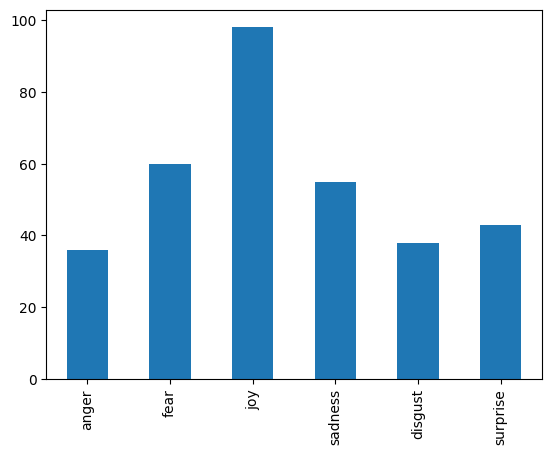

In [16]:
dev_ron[attributes].sum().plot.bar()

In [12]:
dev_ron.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,ron_dev_track_b_00001,Petarde de război folosite la miting DOVADA FOTO,0,0,1,0,0,1
1,ron_dev_track_b_00002,Mia placut cum a fost <|PERSON|> ca invitat la...,0,0,0,2,0,0
2,ron_dev_track_b_00003,Interviu în exclusivitate cu <|PERSON|> după p...,0,0,0,0,0,0
3,ron_dev_track_b_00004,SENZAȚIONAL VIRUSUL UCIGAȘ FĂCUT DE MASONI ACU...,1,2,2,0,1,2
4,ron_dev_track_b_00005,„Oamenii buni sunt foarte rari în ziua de azi ...,1,1,2,0,2,0


In [13]:
test_ron.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,ron_test_track_b_00001,Bărbat amendat după o postare injurioasă pe o ...,NaN,NaN,NaN,NaN,NaN,NaN
1,ron_test_track_b_00002,Respect Dl <|PERSON|> Mă bucur să aud că în sf...,NaN,NaN,NaN,NaN,NaN,NaN
2,ron_test_track_b_00003,Radiografia unui eșec Metroul din Drumul 16 mi...,NaN,NaN,NaN,NaN,NaN,NaN
3,ron_test_track_b_00004,povestea românului emigrat în SUA care din tur...,NaN,NaN,NaN,NaN,NaN,NaN
4,ron_test_track_b_00005,Să ne trăiți întru mulți ani binecuvântațiPERS...,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
test_ron.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        1119 non-null   object 
 1   text      1119 non-null   object 
 2   anger     0 non-null      float64
 3   disgust   0 non-null      float64
 4   fear      0 non-null      float64
 5   joy       0 non-null      float64
 6   sadness   0 non-null      float64
 7   surprise  0 non-null      float64
dtypes: float64(6), object(2)
memory usage: 70.1+ KB


In [7]:
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness","surprise"]

In [8]:
from peft import get_peft_model, LoraConfig, TaskType


lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  
    r=16, 
    lora_alpha=64,  
    lora_dropout=0.1,  
    bias="none"  
)

# Twitter XLM RoBERTa Base Sentiment

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 1,185,030 || all params: 279,233,292 || trainable%: 0.4244
None


In [ ]:
def tokenize_with_emotions(batch):
    emotions = "anger, disgust, fear, joy, sadness, or surprise?"  
    return tokenizer(emotions, batch['text'], padding=True, truncation=True, max_length=128)

In [21]:
def encode_data_with_demux(df, tokenizer):
    emotions = ["anger", "disgust", "fear", "joy", "sadness","surprise"]
    text_with_emotions = [", ".join(emotions) + "?" + " " + t for t in df['text']]
    encodings = tokenizer(text_with_emotions, truncation=True, padding=True, max_length=128)
    labels = df[['anger', 'disgust', 'fear', 'joy', 'sadness',"surprise"]].fillna(0).values
    return encodings, labels

In [22]:
train_encodings, train_labels = encode_data_with_demux(train_ron, tokenizer)
dev_encodings, dev_labels = encode_data_with_demux(dev_ron, tokenizer)

In [23]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [24]:
train_dataset = CustomDataset(train_encodings, train_labels)
dev_dataset = CustomDataset(dev_encodings, dev_labels)

In [ ]:
def calculate_token_lengths(texts, tokenizer):
    token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in texts]
    return token_lengths

train_lengths = calculate_token_lengths(train_ron['text'], tokenizer)
dev_lengths = calculate_token_lengths(dev_ron['text'], tokenizer)
test_lengths = calculate_token_lengths(test_ron['text'], tokenizer)

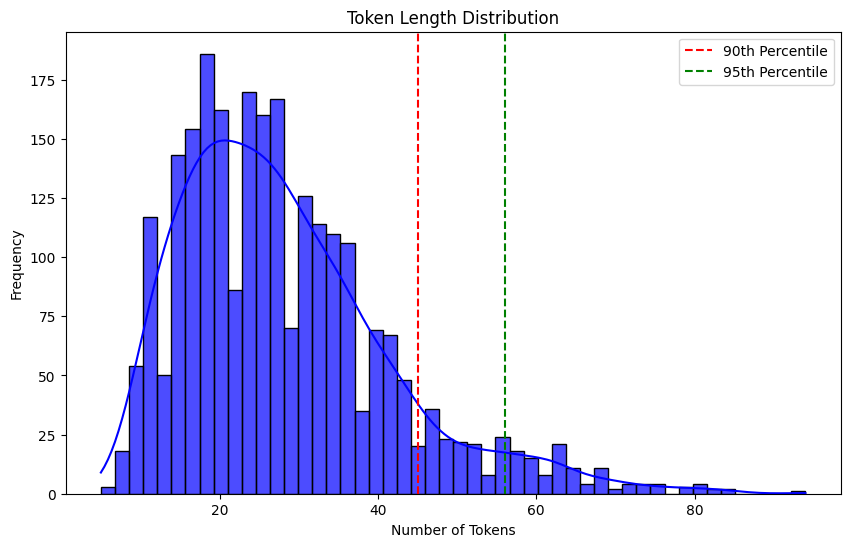

In [ ]:
all_lengths = train_lengths + dev_lengths + test_lengths

plt.figure(figsize=(10, 6))
sns.histplot(all_lengths, bins=50, kde=True, color='blue', alpha=0.7)
plt.axvline(x=np.percentile(all_lengths, 90), color='red', linestyle='--', label='90th Percentile')
plt.axvline(x=np.percentile(all_lengths, 95), color='green', linestyle='--', label='95th Percentile')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [25]:
from transformers import EarlyStoppingCallback

In [27]:
import torch
import torch.nn as nn

class custom_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, outputs, labels):
        return self.mse_loss(outputs, labels)

In [ ]:
from scipy.stats import pearsonr

def compute_pearson_corr(predictions, labels):
    """
    Compute Pearson Correlation between predictions and labels.
    """
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    
    corr, _ = pearsonr(predictions.flatten(), labels.flatten())
    return corr

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = custom_loss()

    def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
        """
        Custom loss function for the Hugging Face Trainer.
        """
        labels = inputs.pop("labels")  # Extract labels
        outputs = model(**inputs)      # Forward pass
        logits = outputs.logits        # Extract logits

        loss = self.loss_fn(logits, labels) 

        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(p: EvalPrediction):
    """
    Compute metrics for evaluation, including Pearson Correlation, Accuracy, Precision, Recall, and F1 score.
    """
    predictions, labels = p.predictions, p.label_ids
    
    predictions_rounded = np.round(predictions).astype(int)
    
    labels_flattened = labels.flatten()
    predictions_flattened = predictions_rounded.flatten()
    
    pearson_corr = compute_pearson_corr(predictions, labels)
    overall_accuracy = accuracy_score(labels_flattened, predictions_flattened)
    precision = precision_score(labels_flattened, predictions_flattened, average='macro')
    recall = recall_score(labels_flattened, predictions_flattened, average='macro')
    f1 = f1_score(labels_flattened, predictions_flattened, average='macro')
    
    return {
        "pearson_corr": pearson_corr,
        "overall_accuracy": overall_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

In [34]:
training_args = TrainingArguments(
    output_dir='./results/ron/xlm-roberta-sentiment-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model="pearson_corr",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [31]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  
    early_stopping_threshold=0.00001  
)

In [36]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [32]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [38]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Pearson Corr,Overall Accuracy,Precision,Recall,F1 Score
500,0.293800,0.317352,0.691473,0.714092,0.463994,0.423402,0.423732
1000,0.267000,0.294364,0.719686,0.718157,0.464687,0.449023,0.440892
1500,0.245800,0.287122,0.730719,0.719512,0.560468,0.491125,0.496543
2000,0.234900,0.274417,0.744485,0.731707,0.467872,0.464585,0.454394
2500,0.225400,0.270737,0.749972,0.760163,0.565127,0.528596,0.534799
3000,0.219500,0.262593,0.756221,0.758808,0.483218,0.487067,0.479210
3500,0.211400,0.261813,0.759787,0.761518,0.568370,0.537231,0.543238
4000,0.207100,0.261128,0.761579,0.761518,0.580684,0.553420,0.557745
4500,0.202800,0.256649,0.764598,0.752033,0.579208,0.550841,0.554752
5000,0.197000,0.257161,0.764638,0.758808,0.570605,0.529939,0.539060


In [ ]:
output_dir = "/kaggle/working/" 

model.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /kaggle/working/


In [ ]:
predictions, labels, _ = trainer.predict(dev_dataset) 

clipped_predictions = np.clip(predictions, 0, 3)

discrete_predictions = np.round(clipped_predictions).astype(int)

print("Discrete predictions (0-3):", discrete_predictions)

Discrete predictions (0-3): [[0 0 0 0 0 1]
 [0 0 0 2 0 0]
 [0 0 0 0 0 0]
 [0 0 2 0 1 1]
 [0 0 2 0 2 0]
 [0 0 2 0 1 0]
 [0 0 0 1 0 0]
 [0 0 1 0 1 0]
 [0 0 0 2 0 0]
 [0 0 1 0 0 0]
 [0 0 0 2 0 1]
 [1 2 0 0 1 0]
 [0 0 0 0 0 0]
 [0 1 0 0 1 1]
 [0 0 2 0 0 0]
 [1 1 1 0 1 0]
 [0 0 0 2 0 1]
 [0 0 0 3 0 0]
 [1 1 2 0 0 0]
 [0 1 0 0 1 1]
 [0 0 0 0 0 0]
 [0 0 0 2 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 1]
 [0 0 0 2 0 0]
 [0 0 0 2 0 1]
 [0 0 0 2 0 0]
 [1 1 1 0 1 0]
 [0 0 0 2 0 1]
 [0 0 0 3 0 1]
 [1 1 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 2 0 1 0]
 [0 0 0 3 0 0]
 [0 0 0 2 0 0]
 [0 0 0 3 0 0]
 [1 1 0 0 1 0]
 [0 0 1 0 1 1]
 [0 0 2 0 1 0]
 [0 0 2 0 1 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [0 0 2 0 0 0]
 [0 0 0 2 0 0]
 [0 1 1 0 1 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 1]
 [0 0 0 3 0 1]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [0 0 0 3 0 1]
 [0 0 2 0 1 1]
 [1 1 1 0 1 1]
 [1 1 0 0 1 1]
 [1 1 0 0 0 0]
 [1 1 1 0 1 0]
 [0 0 1 0 2 1]
 [1 1 0 0 1 0]
 [0 0 0 2 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 2 1]
 [1 1 1 0 1 

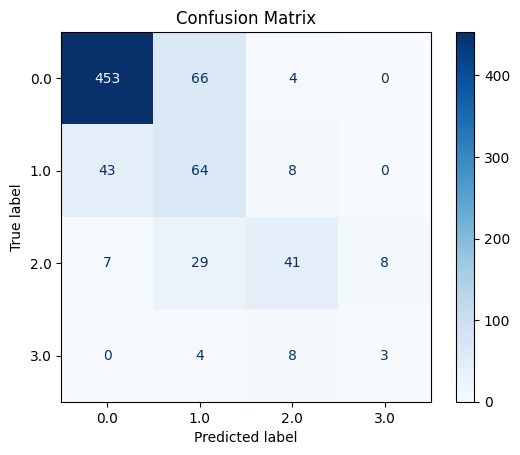

In [ ]:
predictions_flattened = discrete_predictions.ravel()
labels_flattened = labels.ravel()

conf_matrix = confusion_matrix(labels_flattened, predictions_flattened)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels_flattened))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [42]:
pre=np.round(predictions).astype(int)

In [ ]:
test_encodings = tokenizer(list(test_ron['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_ron), 6))) 
test_results = trainer.predict(test_dataset)
predicts = np.round(test_results.predictions).astype(int)

In [45]:
test_ron[['anger', 'disgust', 'fear', 'joy', 'sadness','surprise']] = predicts
test_ron.to_csv('test_predictions_ron_xlm_roberta_sentiment_v1.csv', index=False)

# BERT Base Multilingual Cased

In [9]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-multilingual-cased')
model = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-multilingual-cased',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 594,438 || all params: 178,452,492 || trainable%: 0.3331
None


In [24]:
training_args = TrainingArguments(
    output_dir='./results/ron/bert-base-multi-case-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model="pearson_corr",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [25]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [26]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Pearson Corr,Overall Accuracy,Precision,Recall,F1 Score
500,0.478000,0.478626,0.478103,0.608401,0.247323,0.289247,0.260186
1000,0.382200,0.392852,0.587473,0.658537,0.408915,0.357125,0.358661
1500,0.346000,0.374358,0.613689,0.681572,0.422146,0.374337,0.377751
2000,0.322000,0.369398,0.620538,0.682927,0.419314,0.362338,0.366460
2500,0.320700,0.361152,0.633084,0.689702,0.419524,0.362870,0.370754
3000,0.307400,0.360505,0.634606,0.701897,0.507344,0.383361,0.403326
3500,0.301000,0.355928,0.641927,0.705962,0.544954,0.425491,0.454860
4000,0.294800,0.355763,0.641631,0.714092,0.549915,0.425896,0.455570
4500,0.291400,0.352300,0.645671,0.705962,0.482397,0.392346,0.409658
5000,0.285300,0.351683,0.647266,0.710027,0.524148,0.411503,0.437995


In [ ]:
output_dir = "/kaggle/working/" 

model.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /kaggle/working/


In [ ]:
predictions, labels, _ = trainer.predict(dev_dataset)  

clipped_predictions = np.clip(predictions, 0, 3)

discrete_predictions = np.round(clipped_predictions).astype(int)

print("Discrete predictions (0-3):", discrete_predictions)

Discrete predictions (0-3): [[0 0 0 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 0 0]
 [0 0 1 1 1 1]
 [1 1 2 0 1 1]
 [0 0 1 0 1 0]
 [0 0 0 1 0 0]
 [0 0 1 0 1 0]
 [0 0 0 2 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 1 0 1 0]
 [0 0 0 0 0 0]
 [0 1 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 1 0]
 [0 1 1 0 1 0]
 [0 0 0 3 0 1]
 [0 0 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 1 0 1 0]
 [0 0 0 2 0 1]
 [0 0 0 1 0 0]
 [0 0 0 2 0 0]
 [0 1 1 0 1 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 1]
 [0 1 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [0 0 0 1 0 0]
 [0 1 1 0 1 0]
 [0 0 1 1 0 0]
 [0 0 1 0 1 0]
 [0 0 0 3 0 0]
 [0 0 0 2 0 0]
 [0 0 1 0 1 0]
 [0 0 0 1 0 0]
 [0 1 1 0 1 0]
 [0 0 0 2 0 1]
 [0 0 0 0 0 0]
 [0 0 0 2 0 0]
 [0 0 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 2 0 0]
 [0 0 1 1 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 2 0 0]
 [0 0 1 0 0 0]
 [0 1 1 0 1 0]
 [0 0 1 0 1 1]
 [0 0 1 0 1 0]
 [0 0 0 2 0 0]
 [0 0 0 0 0 0]
 [1 0 2 0 2 1]
 [1 1 2 0 1 

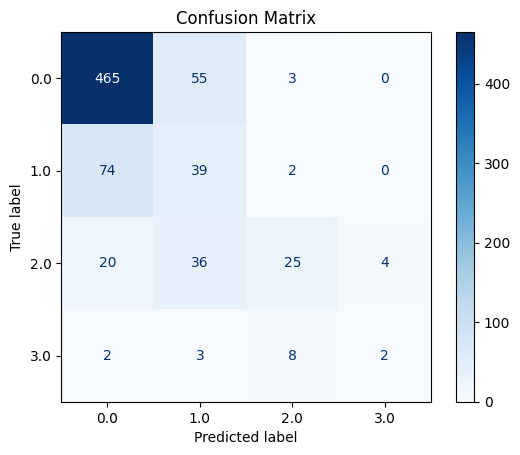

In [ ]:
predictions_flattened = discrete_predictions.ravel()
labels_flattened = labels.ravel()

conf_matrix = confusion_matrix(labels_flattened, predictions_flattened)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels_flattened))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [30]:
test_encodings = tokenizer(list(test_ron['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_ron), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
predicts = np.round(test_results.predictions).astype(int)

In [32]:
test_ron[['anger', 'disgust', 'fear', 'joy', 'sadness','surprise']] = predicts
test_ron.to_csv('test_predictions_ron_bert_base_multiling_cased_v1.csv', index=False)

# XLM RoBERTa Base

In [18]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/xlm-roberta-base',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 1,185,030 || all params: 279,233,292 || trainable%: 0.4244
None


In [33]:
training_args = TrainingArguments(
    output_dir='./results/ron/xlm-roberta-base-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model="pearson_corr",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [34]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [35]:
with mock.patch('wandb.init', return_value=Dummy()):


    
    trainer.train()

Step,Training Loss,Validation Loss,Pearson Corr,Overall Accuracy,Precision,Recall,F1 Score
500,0.433500,0.383290,0.609391,0.674797,0.433816,0.361004,0.369039
1000,0.302700,0.312443,0.697305,0.703252,0.517409,0.457844,0.460838
1500,0.279300,0.294733,0.721198,0.710027,0.525744,0.493506,0.492634
2000,0.259600,0.277583,0.740328,0.743902,0.563069,0.529035,0.530424
2500,0.246600,0.267467,0.750893,0.754743,0.581197,0.548119,0.549817
3000,0.240300,0.252270,0.766657,0.758808,0.596035,0.565422,0.566578
3500,0.226700,0.249923,0.768331,0.762873,0.601105,0.578118,0.575253
4000,0.226400,0.251595,0.770407,0.762873,0.591079,0.607265,0.570921
4500,0.221500,0.248349,0.773269,0.762873,0.584826,0.582439,0.563814
5000,0.221500,0.247699,0.773003,0.765583,0.597934,0.583233,0.574971


In [ ]:
output_dir = "/kaggle/working/" 

model.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /kaggle/working/


In [ ]:
predictions, labels, _ = trainer.predict(dev_dataset) 

clipped_predictions = np.clip(predictions, 0, 3)

discrete_predictions = np.round(clipped_predictions).astype(int)

print("Discrete predictions (0-3):", discrete_predictions)

Discrete predictions (0-3): [[0 1 0 0 0 1]
 [0 0 0 2 0 0]
 [0 0 0 0 0 0]
 [0 1 1 0 1 1]
 [1 0 2 0 2 0]
 [0 0 2 0 0 0]
 [0 0 0 1 0 1]
 [0 0 1 0 1 0]
 [0 0 0 2 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [1 1 0 0 1 0]
 [0 0 0 0 0 0]
 [0 1 1 0 1 1]
 [0 0 1 0 0 0]
 [1 1 1 0 1 0]
 [0 0 0 2 0 1]
 [0 0 0 3 0 0]
 [1 1 1 0 1 0]
 [0 1 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 3 0 0]
 [0 0 1 0 1 0]
 [0 0 1 0 1 0]
 [0 0 2 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 2 0 1]
 [0 0 0 2 0 0]
 [0 0 1 0 1 0]
 [0 0 0 2 0 1]
 [0 0 0 3 0 1]
 [1 1 2 0 1 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 3 0 1]
 [0 0 0 2 0 0]
 [0 0 0 3 0 0]
 [1 1 1 0 1 0]
 [0 0 2 0 1 1]
 [0 0 2 0 1 0]
 [0 0 2 0 1 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [0 0 2 0 1 1]
 [0 0 0 3 0 0]
 [1 1 2 0 1 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 1]
 [0 0 1 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 2 0 0]
 [0 0 0 3 0 0]
 [0 0 0 3 0 1]
 [0 0 2 0 1 1]
 [0 0 1 0 0 0]
 [1 2 0 0 1 0]
 [0 0 0 0 0 0]
 [1 1 0 0 1 0]
 [0 0 2 0 2 1]
 [1 1 0 0 1 0]
 [0 0 0 2 0 1]
 [0 0 0 1 0 0]
 [0 0 2 0 2 1]
 [1 1 2 0 2 

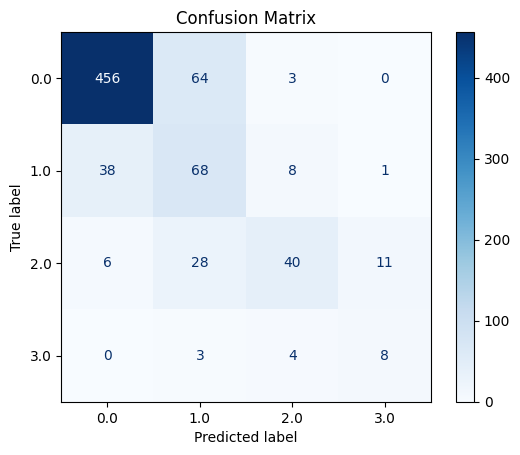

In [ ]:
predictions_flattened = discrete_predictions.ravel()
labels_flattened = labels.ravel()

conf_matrix = confusion_matrix(labels_flattened, predictions_flattened)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels_flattened))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
test_encodings = tokenizer(list(test_ron['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_ron), 6)))  
test_results = trainer.predict(test_dataset)
predicts=np.round(test_results.predictions).astype(int)

In [40]:
test_ron[['anger', 'disgust', 'fear', 'joy', 'sadness','surprise']] = predicts
test_ron.to_csv('test_predictions_ron_xlmroberta_base_v1.csv', index=False)